# Setup

In [1]:
import pandas as pd
import torch
import numpy as np
from scipy.signal import butter, filtfilt, iirnotch
import torch
from matplotlib import pyplot as plt
import os
import pandas as pd

#  0 - unmarked data,
#  1 - hand at rest, 
#  2 - fist, 
#  3 - wrist flexion,
#  4 – wrist extension,
#  5 – radial deviations,
#  6 - ulnar deviations,

poses ={1 : "Rest", 
        2 : "Fist", 
        3 : "Flexion",
        4 : "Extension",
        5 :" Radial",
        6 : "Ulnar"}

# Data loading

In [ ]:
DATA_ROOT = 'ALL EMG/SNR_Testing' # data root folder

CHANNELS = [f' EXG Channel {i}' for i in range(8)]
fs = 250        # Sampling frequency in Hz
lowcut = 30     # Bandpass lower cutoff (Hz)
highcut = 124   # Bandpass upper cutoff (Hz)
notch_freq = 50 # Notch filter center freq (Hz)

# Filter functions
def bandpass_filter(data, lowcut, highcut, fs, order=8):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

def notch_filter(data, notch_freq, fs, q=30):
    nyq = 0.5 * fs
    w0 = notch_freq / nyq
    b, a = iirnotch(w0, q)
    return filtfilt(b, a, data)

# Processing
all_dfs = []

for folder in os.listdir(DATA_ROOT):
    folder_path = os.path.join(DATA_ROOT, folder)
    if not os.path.isdir(folder_path):
        continue

    file_path = os.path.join(folder_path, 'labeled_emg_output.txt')
    if not os.path.exists(file_path):
        continue

    try:
        df = pd.read_csv(file_path, comment='%', skiprows=0)
        if any(col not in df.columns for col in CHANNELS):
            print(f"Missing expected channels in {file_path}, skipping.")
            continue
        
        # Flip if right arm
        if 'right' in folder.lower():
            df[CHANNELS] = df[CHANNELS].iloc[:, ::-1].values

        # if 'ao' in folder.lower() or 'set' in folder.lower():
        # Filter and normalize each channel
        for ch in CHANNELS:
            filtered = bandpass_filter(df[ch], lowcut, highcut, fs)
            filtered = notch_filter(filtered, notch_freq, fs)
            filtered = np.clip(filtered, -600, 600)

            
            # Z-score normalize after filtering
            df[ch] = (filtered - np.mean(filtered)) / np.std(filtered, ddof=1)
            # df[ch] = filtered

            # Remove rows where class == 0
            df = df[df['class'] != 0]


        all_dfs.append(df)
        print(f"Processed: {file_path}")
    except Exception as e:
        print(f"Error in {file_path}: {e}")

# Concatenate all processed recordings
if all_dfs:
    full_df = pd.concat(all_dfs, ignore_index=True)
    print(f"Combined DataFrame shape: {full_df.shape}")
else:
    print("No valid EMG recordings were processed.")

print(f"{(len(full_df) / 250)/60} Minutes of data")

Processed: ALL EMG/SNR_Testing/snr_test1_2025-05-30_16-29-05/labeled_emg_output.txt
Processed: ALL EMG/SNR_Testing/snr_test2_2025-05-30_16-33-00/labeled_emg_output.txt
Combined DataFrame shape: (37773, 26)
2.5182 Minutes of data


# Signal Quality Testing

In [14]:
import numpy as np
import pandas as pd

# Define classes
rest_df = full_df[full_df['class'] == 1]
pose_classes = [2, 3, 4, 5, 6]
channel_names = [f' EXG Channel {i}' for i in range(8)]

# Compute power function
def compute_power(x):
    return np.mean(x**2)

# Dictionary to store results
snr_per_pose = {}

# Loop through each pose class
for pose_class in pose_classes:
    pose_df = full_df[full_df['class'] == pose_class]
    pose_name = poses[pose_class]

    snr_per_pose[pose_name] = []

    for ch in channel_names:
        rest_power = compute_power(rest_df[ch].values)
        active_power = compute_power(pose_df[ch].values)

        # Compute SNR
        if rest_power == 0:
            snr_db = np.inf
        else:
            snr_db = 10 * np.log10(active_power / rest_power)

        snr_per_pose[pose_name].append(snr_db)

# Convert to DataFrame
snr_pose_df = pd.DataFrame(snr_per_pose, index=[f'Channel {i}' for i in range(8)])

# Add average column across poses
snr_pose_df["Average"] = snr_pose_df.mean(axis=1)

# Round for readability
print(snr_pose_df.round(2))


           Fist  Flexion  Extension   Radial  Ulnar  Average
Channel 0 -0.60    -0.30      -0.83    -0.56   0.09    -0.44
Channel 1 -0.06    -0.05      -0.05     0.07  -0.12    -0.04
Channel 2  0.06    -0.02      -0.34    -0.19  -0.09    -0.12
Channel 3 -1.92    -2.29      -0.42    -0.54  -0.96    -1.23
Channel 4 -0.11    -0.10       1.19     0.11  -0.13     0.19
Channel 5  0.16     0.51       2.33    -1.51   0.39     0.38
Channel 6  0.05     0.24      -0.35     0.21  -0.20    -0.01
Channel 7 -1.10    -1.90      -0.46     0.76  -1.80    -0.90


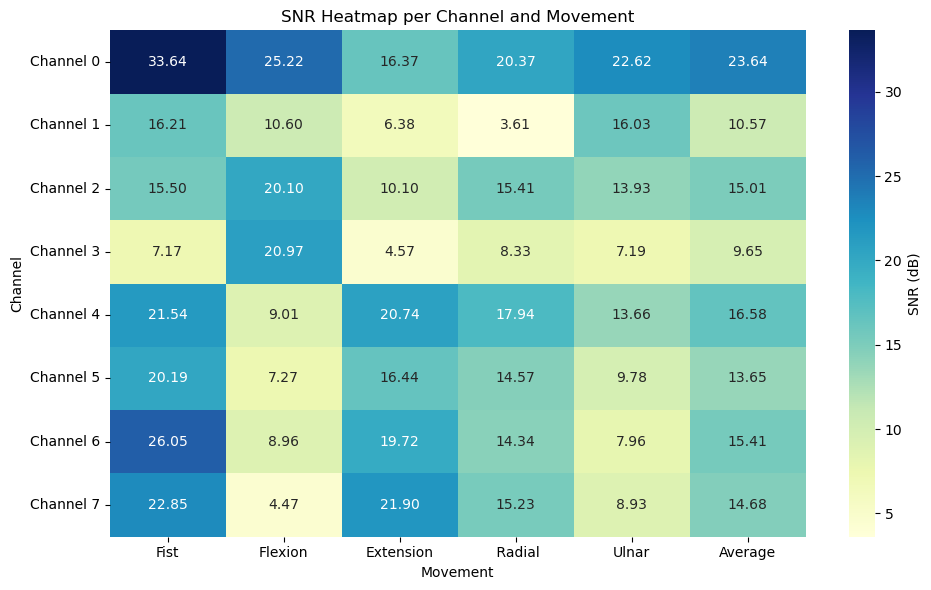

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(snr_pose_df, annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'SNR (dB)'})
plt.title("SNR Heatmap per Channel and Movement")
plt.xlabel("Movement")
plt.ylabel("Channel")
plt.tight_layout()
plt.show()

             Average Motion Artifact Drift per Channel (µV)
                  Channel 0  Channel 1  Channel 2  Channel 3  Channel 4  \
Fist                 889.32     592.41     567.35     688.79     278.24   
Flexion              938.63     540.09     562.68    1804.36     533.11   
Extension            633.57     237.96     524.03     632.57    2319.90   
Radial Deviation     328.51     202.38     414.61     517.70     261.53   
Ulnar Deviation      435.72     643.53     381.45     920.32     427.79   

                  Channel 5  Channel 6  Channel 7  
Fist                 619.64     827.65     997.22  
Flexion              927.83    1252.27     691.81  
Extension           2898.93    1131.23    1224.04  
Radial Deviation     588.70     506.76     430.46  
Ulnar Deviation      796.12     563.21     571.21  

  Average Motion Artifact Drift Across All Channels
(Calculated as mean signal range in µV)
Fist                : 682.58 µV
Flexion             : 906.35 µV
Extension           

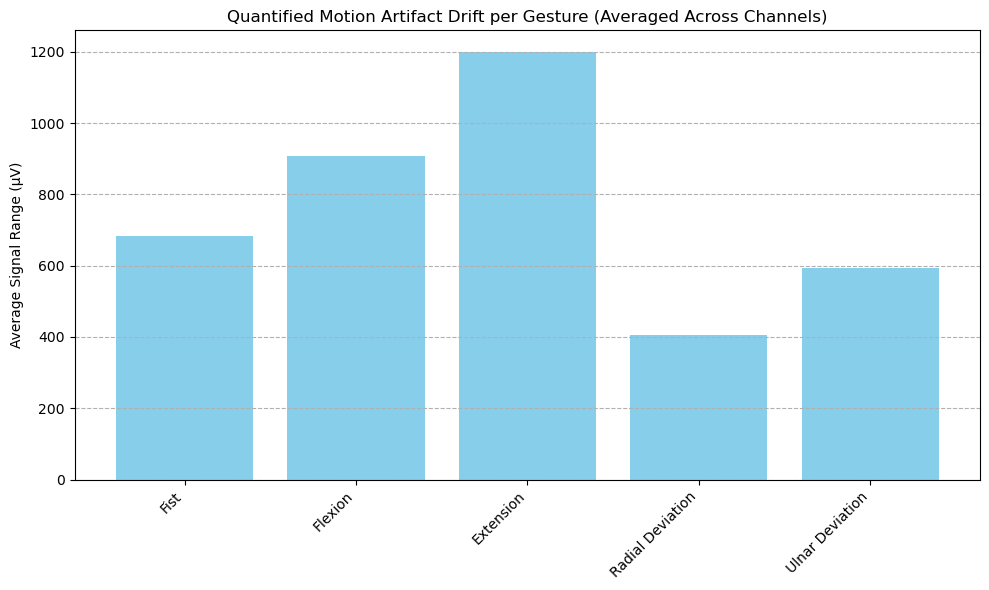

In [ ]:
# ! operates on the RAW signal not the filtered signal, for motion artifact insights.

# import numpy as np
# import pandas as pd
# import os
# from matplotlib import pyplot as plt


# poses = {
#     1: "Rest",
#     2: "Fist",
#     3: "Flexion",
#     4: "Extension",
#     5: "Radial Deviation",
#     6: "Ulnar Deviation"
# }

# CHANNELS = [f' EXG Channel {i}' for i in range(8)]
# fs = 250  # Sampling frequency in Hz



# def find_movement_segments(df, class_label):
#     """
#     Finds the start and end indices of all continuous segments
#     for a given class label.
#     """
#     is_class = df['class'] == class_label
#     class_changes = is_class.ne(is_class.shift())
#     block_ids = class_changes.cumsum()
#     target_blocks = block_ids[is_class]
    
#     if target_blocks.empty:
#         return []
        
#     segments = target_blocks.groupby(target_blocks).apply(
#         lambda x: (x.index[0], x.index[-1])
#     ).tolist()
    
#     return segments

# artifact_ranges = {pose: {ch: [] for ch in CHANNELS} for pose in poses.values() if pose != "Rest"}

# for class_id, pose_name in poses.items():
#     if class_id == 1:  # Skip the 'Rest' class
#         continue

#     segments = find_movement_segments(full_df, class_id)
    
#     if not segments:
#         print(f"No segments found for class {class_id} ({pose_name}).")
#         continue

#     for start_idx, end_idx in segments:
#         expanded_start = np.maximum(0, start_idx - fs)
#         expanded_end = np.minimum(len(full_df) - 1, end_idx + fs)
        
#         window_data = full_df.iloc[expanded_start:expanded_end]

#         for ch in CHANNELS:
#             signal_range = window_data[ch].max() - window_data[ch].min()
#             artifact_ranges[pose_name][ch].append(signal_range)

# # 1. Detailed Per-Channel, Per-Pose Table
# per_channel_summary = {}
# for pose_name, channels in artifact_ranges.items():
#     per_channel_summary[pose_name] = {ch_name: np.mean(ranges) if ranges else 0 for ch_name, ranges in channels.items()}

# summary_df = pd.DataFrame(per_channel_summary).T  # Transpose for better readability
# summary_df.columns = [f'Channel {i}' for i in range(8)] # Rename columns

# print("=" * 70)
# print("             Average Motion Artifact Drift per Channel (µV)")
# print("=" * 70)
# print(summary_df.round(2))
# print("=" * 70)


# # 2. Overall Average per Pose (for bar chart and summary text)
# overall_summary = {}
# for pose_name, channels in artifact_ranges.items():
#     all_ranges_for_pose = [item for sublist in channels.values() for item in sublist]
#     if all_ranges_for_pose:
#         overall_summary[pose_name] = np.mean(all_ranges_for_pose)

# print("\n" + "=" * 50)
# print("  Average Motion Artifact Drift Across All Channels")
# print("(Calculated as mean signal range in µV)")
# print("=" * 50)
# for pose_name, avg_range in overall_summary.items():
#     print(f"{pose_name:<20}: {avg_range:.2f} µV")
# print("=" * 50)


# # 3. Optional: Plotting the overall average results for a visual comparison
# if overall_summary:
#     plt.figure(figsize=(10, 6))
#     plt.bar(overall_summary.keys(), overall_summary.values(), color='skyblue')
#     plt.ylabel('Average Signal Range (µV)')
#     plt.title('Quantified Motion Artifact Drift per Gesture (Averaged Across Channels)')
#     plt.xticks(rotation=45, ha='right')
#     plt.tight_layout()
#     plt.grid(axis='y', linestyle='--')
#     plt.show()


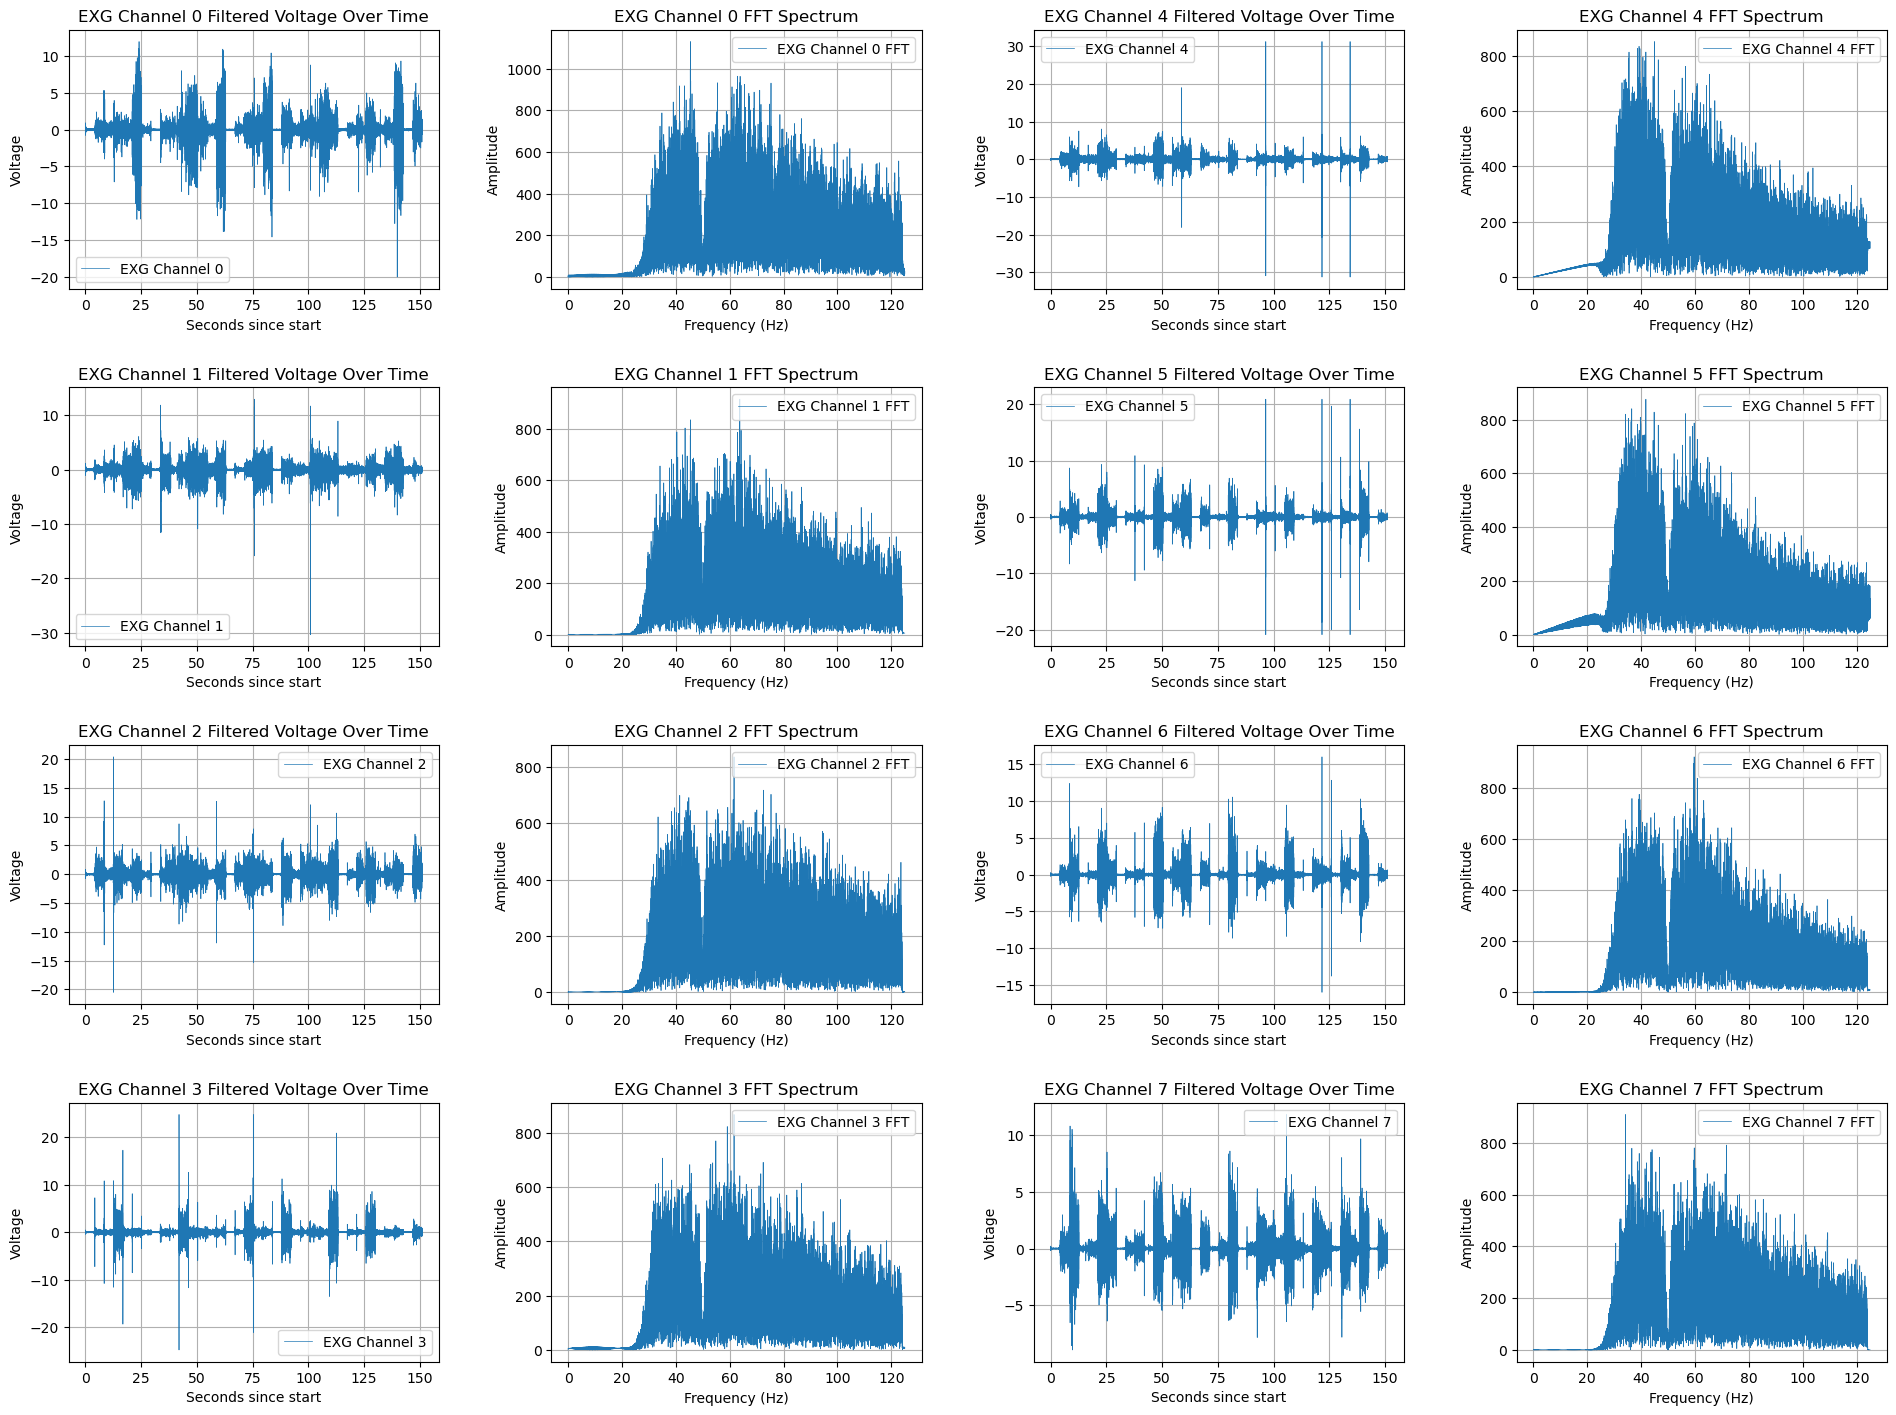

In [3]:
data = full_df

# Compute FFT
def compute_fft(data, fs):
    N = len(data)
    freqs = np.fft.rfftfreq(N, 1/fs)
    fft_values = np.abs(np.fft.rfft(data))
    return freqs, fft_values

# Compute the x-axis values with  sampling rate of 250 Hz
total_samples = len(data)
time_stamps = np.linspace(0, total_samples / fs, total_samples)

# Setup the figure and axes for subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 15))  # Adjust figure size and columns
fig.tight_layout(pad=5.0)  # Adjust spacing between plots

# Plot each EXG channel
for i in range(8):
    channel_name = f' EXG Channel {i}'
    data[channel_name] = data[channel_name]
    
    row = i % 4  # Rows cycle through 0-3
    col_time = 2 * (i // 4)      # Time-domain plot in first column of each group
    col_fft = col_time + 1

    # Time-domain plot
    ax_time = axes[row, col_time]
    ax_time.plot(time_stamps, data[channel_name], label=channel_name.strip(), linewidth=0.5)
    ax_time.set_title(channel_name.strip() + ' Filtered Voltage Over Time')
    ax_time.set_xlabel('Seconds since start')
    ax_time.set_ylabel('Voltage')
    ax_time.legend()
    ax_time.grid(True)

    # Frequency-domain plot-
    ax_fft = axes[row, col_fft]
    freqs, fft_values = compute_fft((data[channel_name]), fs)
    ax_fft.plot(freqs, fft_values, label=f'{channel_name.strip()} FFT', linewidth=0.5)
    ax_fft.set_title(channel_name.strip() + ' FFT Spectrum')
    ax_fft.set_xlabel('Frequency (Hz)')
    ax_fft.set_ylabel('Amplitude')
    ax_fft.legend()
    ax_fft.grid(True)

# Show the plot
plt.show()

### feature extractors

In [ ]:
import numpy as np
from scipy.stats import kurtosis, skew

def iemg(x):
    """Integrated EMG (IEMG)"""
    return np.sum(np.abs(x))

def var(x):
    """Variance"""
    return np.var(x, ddof=1)

def rms(x):
    """Root Mean Square (RMS)"""
    return np.sqrt(np.mean(x**2))

def kurt(x):
    """Kurtosis"""
    return kurtosis(x, fisher=True)

def ln_rms(x):
    """Log RMS"""
    return np.log(rms(x) + 1e-10)  # Add epsilon to avoid log(0)

def aac(x):
    """Average Amplitude Change (AAC)"""
    return np.sum(np.abs(np.diff(x))) / len(x)

def mavs(x, segment=10):
    """Mean Absolute Value Slope (MAVS)"""
    split = np.array_split(np.abs(x), segment)
    means = [np.mean(seg) for seg in split]
    return np.mean(np.abs(np.diff(means))) if len(means) > 1 else 0

def ssc(x):
    """Slope Sign Changes (SSC)"""
    return np.sum(np.diff(np.sign(np.diff(x))) != 0)

def wamp(x, threshold=10):
    """Willison Amplitude (WAMP)"""
    return np.sum(np.abs(np.diff(x)) >= threshold)

def skewness(x):
    """Skewness"""
    return skew(x)

def ssi(x):
    """Simple Square Integral (SSI)"""
    return np.sum(x**2)

def mav(x):
    """Mean Absolute Value (MAV)"""
    return np.mean(np.abs(x))

def mav1(x, threshold_ratio=0.25):
    """Modified Mean Absolute Value 1 (MAV1)"""
    th = threshold_ratio * np.max(np.abs(x))
    return np.mean([abs(xi) if abs(xi) > th else 0 for xi in x])

def mav2(x, threshold_ratio=0.25):
    """Modified Mean Absolute Value 2 (MAV2)"""
    th = threshold_ratio * np.max(np.abs(x))
    return np.mean([abs(xi) if abs(xi) < th else 0 for xi in x])


def tm(x, order=4):
    """Absolute Temporal Moment (TM)"""
    return np.mean(np.abs(x)**order)

def myop(x, threshold=16):
    """Myopulse Percentage Rate (MYOP)"""
    return np.sum(np.abs(x) > threshold)

def zc(x, threshold=10):
    """Zero Crossings (ZC)"""
    return np.sum((x[:-1] * x[1:] < 0) & (np.abs(x[:-1] - x[1:]) >= threshold))

feature_extractors = [
    iemg, var, rms, ln_rms, kurt, skewness,
    aac, mav1, mav2, mav, mavs,
    ssc, ssi, tm, wamp, myop, zc
]


# rfe feature selection

In [7]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.tsa.ar_model import AutoReg
from itertools import combinations
from scipy.stats import kurtosis, skew
from sklearn.feature_selection import RFE

def get_feature_names(feature_extractors=feature_extractors, n_channels=8):
    names = []
    for ch in range(n_channels):
        for extractor in feature_extractors:
            names.append(f"{extractor.__name__}_ch{ch}")

    return names

def run_rfe(X_train, y_train, feature_names, n_features_to_select=10):
    """
    Perform RFE and print selected feature names.

    Returns:
    - X_train_reduced: reduced feature matrix
    - support_mask: boolean array of selected features
    - rankings: array of feature rankings
    - selected_names: list of selected feature names
    """
    print(f"\nRunning RFE to select top {n_features_to_select} features...")

    estimator = RandomForestClassifier(n_estimators=100, random_state=42)
    rfe = RFE(estimator=estimator, n_features_to_select=n_features_to_select, step=1)
    rfe.fit(X_train, y_train)

    support_mask = rfe.support_
    rankings = rfe.ranking_
    selected_names = [name for name, keep in zip(feature_names, support_mask) if keep]

    print("Selected feature names:")
    for name in selected_names:
        print(f" - {name}")

    return X_train[:, support_mask], support_mask, rankings, selected_names



# simple model training, grid search for window size params, augmentation

In [8]:
import numpy as np
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.tsa.ar_model import AutoReg
from itertools import combinations
from scipy.stats import kurtosis, skew
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# ====== Augmentation ======
def add_noise(x, min_noise_level=0.1, max_noise_level=0.7):
    factor = np.random.uniform(min_noise_level, max_noise_level)
    return x + np.random.normal(0, factor, x.shape)

def scale_amplitude(x, min_scale=0.7, max_scale=1.3):
    factor = np.random.uniform(min_scale, max_scale)
    return x * factor

def augment_window(window):
    window_aug = window.copy()
    for i in range(8):
        x = window_aug[f' EXG Channel {i}'].values
        x = scale_amplitude(add_noise(x))
        window_aug[f' EXG Channel {i}'] = x
    return window_aug

# ====== Feature Extraction ======
# def extract_features(window, feature_extractors=[var, rms, ln_rms, aac, mav1, mavs, ssc, wamp, skewness, ssi]):
def extract_features(window, feature_extractors=[ln_rms, aac, mavs, ssc, wamp, skewness, ssi]):
    features = []
    channel_data = []

    for i in range(8):
        x = window[f' EXG Channel {i}'].values
        channel_data.append(x)
        for extractor in feature_extractors:
            result = extractor(x)
            features.extend(result if isinstance(result, (list, np.ndarray)) else [result])

    channel_data = np.array(channel_data)
    for i, j in combinations(range(8), 2):
        features.append(np.corrcoef(channel_data[i], channel_data[j])[0, 1])

    return features

# ====== Dataset Preparation ======
def prepare_dataset(data, sampling_rate=250, window_duration=0.128, overlap_percentage=0.75, n_augments=0, test_size=0.3):
    window_size = int(window_duration * sampling_rate)
    step_size = int(window_size * (1 - overlap_percentage))

    X_raw, y_raw = [], []
    num_skipepd = 0
    for start in range(0, len(data) - window_size, step_size):
        window = data.iloc[start:start + window_size]
        try:
            label_counts = window['class'].value_counts(normalize=True)
            dominant_label = label_counts.idxmax()
            if label_counts[dominant_label] < 0.75: 
                num_skipepd += 1
                continue  # Skip if dominant label doesn't cover at least 75%
            label = window['class'].mode()[0]
            X_raw.append(window)
            y_raw.append(label)
        except:
            continue
    print(f"Skipped {num_skipepd} windows because they aren't at least 75% belonging to the mode class. This is {round(num_skipepd*100 / (len(X_raw) + num_skipepd), 2)}% of data")

    # Now split windows (not features) to prevent leakage
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y_raw, test_size=test_size, random_state=42, stratify=y_raw)

    # Extract features
    X_train = [extract_features(w) for w in X_train_raw]
    X_test = [extract_features(w) for w in X_test_raw]

    # Apply augmentations ONLY on training set
    if n_augments > 0:
        for window, label in zip(X_train_raw, y_train):
            for _ in range(n_augments):
                aug_window = augment_window(window)
                X_train.append(extract_features(aug_window))
                y_train.append(label)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# ====== Train & Evaluate ======
def train_and_evaluate_models(X_train, y_train, X_test, y_test, models):
    X_train, y_train = shuffle(X_train, y_train, random_state=42)
    X_test, y_test = shuffle(X_test, y_test, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)




    histories = []
    for name, model in models.items():
        history = model.fit(X_train, y_train)
        histories.append(history)

        print(f"{name} - Train Acc: {model.score(X_train, y_train)*100:.2f}%")
        print(f"{name} - Test Acc: {model.score(X_test, y_test)*100:.2f}%\n")

    return models, scaler, histories

# ====== Real-time Classification ======
def classify_real_time(new_data, model, scaler):
    features = extract_features(new_data)
    scaled = scaler.transform([features])
    return model.predict(scaled)[0]

models = {
    "LDA": LDA(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel='linear', random_state=42),
    "KNN (k=5)": KNeighborsClassifier(n_neighbors=5),
    "KNN (k=10)": KNeighborsClassifier(n_neighbors=10),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Ridge Classifier": RidgeClassifier(),
    "Perceptron": Perceptron(random_state=42),
    "SGD Classifier": SGDClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
}



# wd = [0.128, 0.256, 0.512]
# op = [0, 0.25, 0.5, 0.75]

# for window_duration in wd:
#     for overlap_percentage in op:
#         print(f"\n\n wd: {window_duration} \t op: {overlap_percentage}")
#         X_train, y_train, X_test, y_test = prepare_dataset(data, n_augments=0, window_duration=window_duration, overlap_percentage=overlap_percentage)
#         train_and_evaluate_models(X_train, y_train, X_test, y_test, models)



# run_rfe(X_train, y_train, feature_names=get_feature_names(feature_extractors))

# Feature Selection

In [ ]:
# feature_extractors = [
# iemg, var, mav2, myop, skewness, wamp, zc
# ]
# feature_names = [
# "iemg", "var", "mav2", "myop", "skewness", "wamp", "zc"
# ]

feature_extractors = [ln_rms, aac, mavs, ssc, wamp, skewness, ssi]
feature_names = ["ln_rms", "aac", "mavs", "ssc", "wamp", "skewness", "ssi"]


# Create matrix to hold features per channel
def extract_per_channel_features(window):
    per_channel_feats = {name: [] for name in feature_names}
    for i in range(8):
        x = window[f' EXG Channel {i}'].values
        for name, func in zip(feature_names, feature_extractors):
            val = func(x)
            per_channel_feats[name].append(val)
    return per_channel_feats

window_duration = 0.128
overlap_percentage = 0.75
sampling_rate = 250
window_size = int(window_duration * sampling_rate)
step_size = int(window_size * (1 - overlap_percentage))
X_raw = []
for start in range(0, len(data) - window_size, step_size):
    window = data.iloc[start:start + window_size]
    try:
        label_counts = window['class'].value_counts(normalize=True)
        dominant_label = label_counts.idxmax()
        
        label = window['class'].mode()[0]
        X_raw.append(window)
    except:
        continue

per_channel_feat_dicts = [extract_per_channel_features(w) for w in X_raw]

# Convert list of dicts into a 3D array: (samples, features, channels)
n_samples = len(per_channel_feat_dicts)
n_feats = len(feature_names)
n_channels = 8

features_array = np.zeros((n_samples, n_feats, n_channels))

for i, feat_dict in enumerate(per_channel_feat_dicts):
    for j, name in enumerate(feature_names):
        features_array[i, j, :] = feat_dict[name]

# Average over channels to get (samples, features)
features_avg = np.mean(features_array, axis=2)

# Convert to DataFrame for correlation
df_features = pd.DataFrame(features_avg, columns=feature_names)

# Compute correlation matrix
corr_matrix = df_features.corr()

# Display or return the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create mask for the lower triangle
mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=0)

# Plot heatmap with mask applied
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            mask=mask, 
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8})

plt.title("Average Feature Correlation Matrix (Upper Triangle)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Skipped 1051 windows because they aren't at least 75% belonging to the mode class. This is 1.39% of data


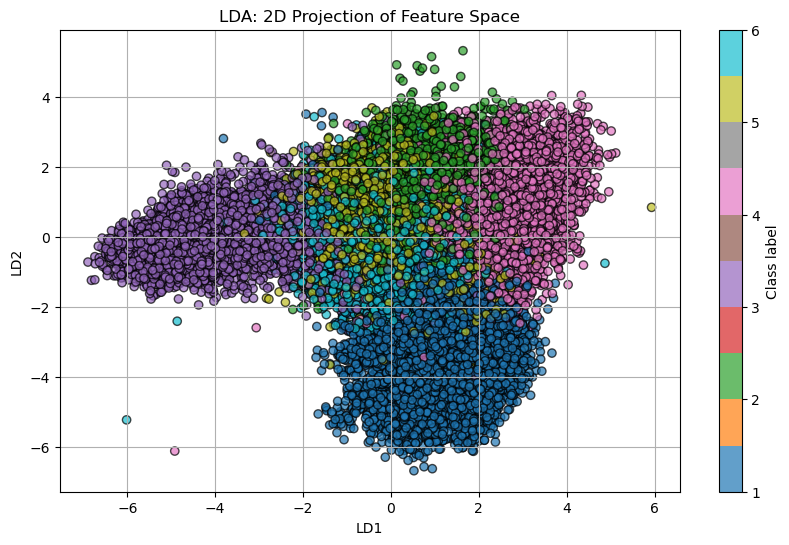

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

X_train, y_train, X_test, y_test = prepare_dataset(data, n_augments=0, window_duration=0.128, overlap_percentage=0.75)


# Combine data and labels
X_all = np.concatenate((X_train, X_test), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

# Assumes you already have X_train, y_train
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_all, y_all)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_lda[:, 0], X_lda[:, 1], c=y_all, cmap='tab10', alpha=0.7, edgecolor='k')
plt.title("LDA: 2D Projection of Feature Space")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.colorbar(scatter, label="Class label")
plt.grid(True)
plt.show()


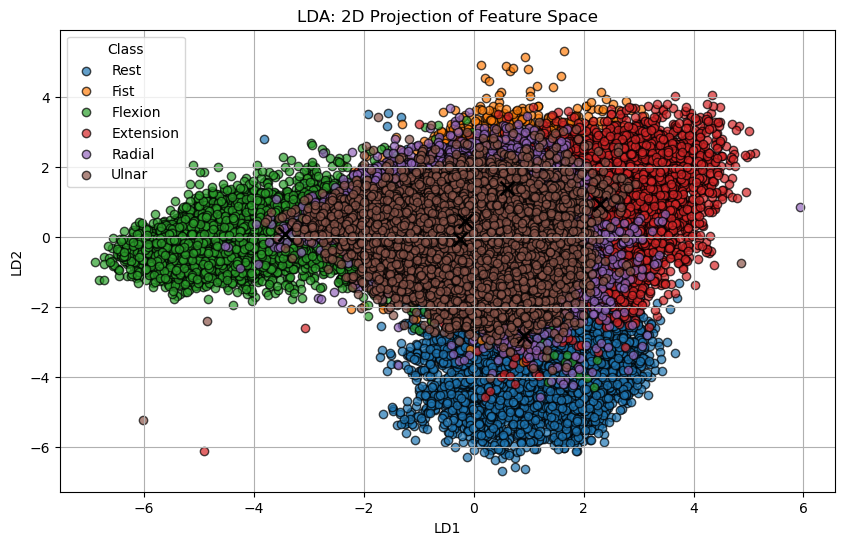

In [ ]:
# Define pose map
pose_map = {
    1: "Rest",
    2: "Fist",
    3: "Flexion",
    4: "Extension",
    5: "Radial",
    6: "Ulnar"
}

# Plot
plt.figure(figsize=(10, 6))
for class_label in np.unique(y_all):
    mask = y_all == class_label
    plt.scatter(
        X_lda[mask, 0],
        X_lda[mask, 1],
        label=pose_map[class_label],
        alpha=0.7,
        edgecolor='k'
    )

    # Plot cluster centre
    class_mean = X_lda[mask].mean(axis=0)
    plt.plot(class_mean[0], class_mean[1], 'x', color='black', markersize=10, markeredgewidth=2)

# Plot decorations
plt.title("LDA: 2D Projection of Feature Space")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.grid(True)
plt.legend(title="Class")
plt.show()

### deep learning flow

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np

# ====== Dataset Preparation ======
def prepare_dataset(data, sampling_rate=250, window_duration=0.5, overlap_percentage=0.125, n_augments=0, test_size=0.15, val_size=0.15):
    window_size = int(window_duration * sampling_rate)
    step_size = int(window_size * (1 - overlap_percentage))

    X_raw, y_raw = [], []
    num_skipped = 0
    for start in range(0, len(data) - window_size, step_size):
        window = data.iloc[start:start + window_size]
        try:
            label_counts = window['class'].value_counts(normalize=True)
            dominant_label = label_counts.idxmax()
            if label_counts[dominant_label] < 0.75: 
                num_skipped += 1
                continue
            label = window['class'].mode()[0]
            X_raw.append(window)
            y_raw.append(label)
        except:
            continue

    total = len(X_raw) + num_skipped
    print(f"Skipped {num_skipped} windows ({round(num_skipped * 100 / total, 2)}% of data)")

    # First split: Train vs Temp (Validation + Test)
    X_train_raw, X_temp_raw, y_train, y_temp = train_test_split(
        X_raw, y_raw, test_size=(test_size + val_size), stratify=y_raw, random_state=42
    )

    # Second split: Validation vs Test
    val_ratio = val_size / (test_size + val_size)
    X_val_raw, X_test_raw, y_val, y_test = train_test_split(
        X_temp_raw, y_temp, test_size=(1 - val_ratio), stratify=y_temp, random_state=42
    )

    # Feature extraction
    X_train = [extract_features(w) for w in X_train_raw]
    X_val = [extract_features(w) for w in X_val_raw]
    X_test = [extract_features(w) for w in X_test_raw]

    # Apply augmentations only to training set
    if n_augments > 0:
        for window, label in zip(X_train_raw, y_train):
            for _ in range(n_augments):
                aug_window = augment_window(window)
                X_train.append(extract_features(aug_window))
                y_train.append(label)

    return (np.array(X_train), np.array(y_train),
            np.array(X_val), np.array(y_val),
            np.array(X_test), np.array(y_test))


X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(data, n_augments=0, window_duration=0.128, overlap_percentage=0.75)

y_train -= 1
y_val -= 1
y_test -= 1

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# ==== Convert labels to one-hot ====
num_classes = len(np.unique(y_train))
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

print(f"Total number of examples: {len(X_train) + len(X_test) + len(X_val)}")

2025-06-11 12:57:12.004951: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-11 12:57:12.315716: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-11 12:57:13.734486: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Skipped 1051 windows (1.39% of data)
Total number of examples: 74511


In [10]:
X_train.shape

(52157, 84)

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        21,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,430 (216.52 KB)

 Trainable params: 55,430 (216.52 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8023 - loss: 0.5925 - val_accuracy: 0.9274 - val_loss: 0.2315
Epoch 2/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9151 - loss: 0.2677 - val_accuracy: 0.9397 - val_loss: 0.1912
Epoch 3/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 3s 779us/step - accuracy: 0.9277 - loss: 0.2216 - val_accuracy: 0.9479 - val_loss: 0.1690
Epoch 4/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9353 - loss: 0.1936 - val_accuracy: 0.9450 - val_loss: 0.1689
Epoch 5/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9414 - loss: 0.1814 - val_accuracy: 0.9536 - val_loss: 0.1487
Epoch 6/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9468 - loss: 0.1607 - val_accuracy: 0.9548 - val_loss: 0.1413
Epoch 7/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9490 - loss: 0.1529 - val_accuracy: 0.9579 - val_loss: 0.1354
Epoch 8/200
3260/3260 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9512 - 

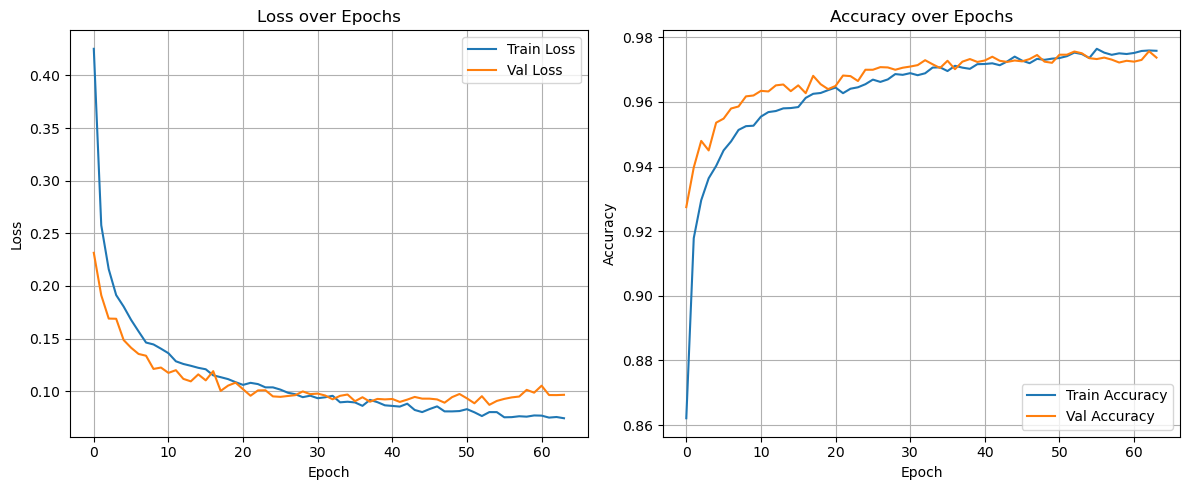

In [11]:
#* ==== Build MLP ====
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
#     Dropout(0.2),
#     Dense(64, activation='relu'),
#     Dropout(0.2),
#     Dense(num_classes, activation='softmax')
# ])

# ==== Build MLP ====
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
print(model.summary())

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

# ==== Train ====
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train_cat,
                    validation_data=(X_val_scaled, y_val_cat),
                    epochs=200,
                    batch_size=16,
                    callbacks=[early_stop],
                    verbose=1,)

# Evaluate
val_loss, val_acc = model.evaluate(X_val_scaled, y_val_cat)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

# ==== Plot loss and accuracy ====
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [12]:
#* final evaluation on test set
# Evaluate
test_loss, test_acc = model.evaluate(X_test_scaled, y_test_cat)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

# model.save('mlp_128_64_128ms_75pc_model.h5')


350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9747 - loss: 0.0891  
Test Accuracy: 97.49%


In [15]:
wd = [0.128, 0.256, 0.512]
op = [0, 0.25, 0.5, 0.75]

for window_duration in wd:
    for overlap_percentage in op:
        if window_duration == 0.128 and overlap_percentage == 0.75: continue
        print(f"\n\n wd: {window_duration} \t op: {overlap_percentage}")
        X_train, y_train, X_val, y_val, X_test, y_test = prepare_dataset(data, n_augments=0, window_duration=window_duration, overlap_percentage=overlap_percentage)

        y_train -= 1
        y_val -= 1
        y_test -= 1

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        # ==== Convert labels to one-hot ====
        num_classes = len(np.unique(y_train))
        y_train_cat = to_categorical(y_train, num_classes)
        y_val_cat = to_categorical(y_val, num_classes)
        y_test_cat = to_categorical(y_test, num_classes)

        model = Sequential([
        Dense(256, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

        model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'],)

        # ==== Train ====
        early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(X_train_scaled, y_train_cat,
                            validation_data=(X_val_scaled, y_val_cat),
                            epochs=200,
                            batch_size=16,
                            callbacks=[early_stop],
                            verbose=1,)

        # Evaluate
        val_loss, val_acc = model.evaluate(X_val_scaled, y_val_cat)
        print(f"Validation Accuracy: {val_acc * 100:.2f}%")



 wd: 0.128 	 op: 0
Skipped 262 windows (1.39% of data)
Epoch 1/200


/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6943 - loss: 0.8644 - val_accuracy: 0.8801 - val_loss: 0.3674
Epoch 2/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8632 - loss: 0.4245 - val_accuracy: 0.9087 - val_loss: 0.2864
Epoch 3/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8876 - loss: 0.3420 - val_accuracy: 0.9238 - val_loss: 0.2480
Epoch 4/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 0.2895 - val_accuracy: 0.9245 - val_loss: 0.2443
Epoch 5/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9093 - loss: 0.2669 - val_accuracy: 0.9320 - val_loss: 0.2268
Epoch 6/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9219 - loss: 0.2428 - val_accuracy: 0.9384 - val_loss: 0.1973
Epoch 7/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9249 - loss: 0.2203 - val_accuracy: 0.9366 - val_loss: 0.2063
Epoch 8/200
815/815 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9233 - loss: 0.2277 - val_accuracy: 0.9356

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7268 - loss: 0.7995 - val_accuracy: 0.9034 - val_loss: 0.3243
Epoch 2/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8745 - loss: 0.3841 - val_accuracy: 0.9240 - val_loss: 0.2621
Epoch 3/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9017 - loss: 0.3017 - val_accuracy: 0.9240 - val_loss: 0.2372
Epoch 4/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9150 - loss: 0.2713 - val_accuracy: 0.9302 - val_loss: 0.2202
Epoch 5/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9192 - loss: 0.2398 - val_accuracy: 0.9291 - val_loss: 0.2238
Epoch 6/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9247 - loss: 0.2225 - val_accuracy: 0.9375 - val_loss: 0.2037
Epoch 7/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9345 - loss: 0.2101 - val_accuracy: 0.9377 - val_loss: 0.2001
Epoch 8/200
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9313 - loss: 0.1986 - val_

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7633 - loss: 0.7077 - val_accuracy: 0.9148 - val_loss: 0.2705
Epoch 2/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8882 - loss: 0.3479 - val_accuracy: 0.9274 - val_loss: 0.2212
Epoch 3/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9074 - loss: 0.2826 - val_accuracy: 0.9415 - val_loss: 0.1835
Epoch 4/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9231 - loss: 0.2369 - val_accuracy: 0.9410 - val_loss: 0.1786
Epoch 5/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9319 - loss: 0.2145 - val_accuracy: 0.9442 - val_loss: 0.1729
Epoch 6/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9344 - loss: 0.2017 - val_accuracy: 0.9472 - val_loss: 0.1604
Epoch 7/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9361 - loss: 0.2016 - val_accuracy: 0.9508 - val_loss: 0.1526
Epoch 8/200
1631/1631 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9411 - loss: 0.1757 - val_

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6639 - loss: 0.9679 - val_accuracy: 0.8910 - val_loss: 0.3929
Epoch 2/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8571 - loss: 0.4281 - val_accuracy: 0.9070 - val_loss: 0.3208
Epoch 3/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8936 - loss: 0.3215 - val_accuracy: 0.9121 - val_loss: 0.2882
Epoch 4/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9100 - loss: 0.2774 - val_accuracy: 0.9237 - val_loss: 0.2696
Epoch 5/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9264 - loss: 0.2233 - val_accuracy: 0.9331 - val_loss: 0.2289
Epoch 6/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9388 - loss: 0.1893 - val_accuracy: 0.9368 - val_loss: 0.2371
Epoch 7/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9410 - loss: 0.1880 - val_accuracy: 0.9382 - val_loss: 0.2159
Epoch 8/200
402/402 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9453 - loss: 0.1719 - val_accuracy: 0.9317

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6807 - loss: 0.8750 - val_accuracy: 0.8991 - val_loss: 0.3404
Epoch 2/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8790 - loss: 0.3724 - val_accuracy: 0.9209 - val_loss: 0.2635
Epoch 3/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9039 - loss: 0.2928 - val_accuracy: 0.9334 - val_loss: 0.2172
Epoch 4/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9218 - loss: 0.2356 - val_accuracy: 0.9362 - val_loss: 0.2009
Epoch 5/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9299 - loss: 0.2114 - val_accuracy: 0.9427 - val_loss: 0.1894
Epoch 6/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9410 - loss: 0.1791 - val_accuracy: 0.9416 - val_loss: 0.1836
Epoch 7/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9474 - loss: 0.1650 - val_accuracy: 0.9400 - val_loss: 0.1806
Epoch 8/200
535/535 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9474 - loss: 0.1617 - val_accuracy: 0.9498

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7185 - loss: 0.8028 - val_accuracy: 0.9000 - val_loss: 0.3239
Epoch 2/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8960 - loss: 0.3262 - val_accuracy: 0.9262 - val_loss: 0.2329
Epoch 3/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9221 - loss: 0.2473 - val_accuracy: 0.9364 - val_loss: 0.2009
Epoch 4/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9281 - loss: 0.2181 - val_accuracy: 0.9437 - val_loss: 0.1881
Epoch 5/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9422 - loss: 0.1776 - val_accuracy: 0.9455 - val_loss: 0.1741
Epoch 6/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9423 - loss: 0.1792 - val_accuracy: 0.9491 - val_loss: 0.1742
Epoch 7/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9484 - loss: 0.1494 - val_accuracy: 0.9477 - val_loss: 0.1717
Epoch 8/200
803/803 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9556 - loss: 0.1402 - val_accuracy: 0.9440

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7783 - loss: 0.6452 - val_accuracy: 0.9230 - val_loss: 0.2500
Epoch 2/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9160 - loss: 0.2599 - val_accuracy: 0.9422 - val_loss: 0.1810
Epoch 3/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9367 - loss: 0.1885 - val_accuracy: 0.9477 - val_loss: 0.1567
Epoch 4/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9513 - loss: 0.1536 - val_accuracy: 0.9535 - val_loss: 0.1457
Epoch 5/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9518 - loss: 0.1407 - val_accuracy: 0.9571 - val_loss: 0.1315
Epoch 6/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9562 - loss: 0.1367 - val_accuracy: 0.9580 - val_loss: 0.1330
Epoch 7/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9623 - loss: 0.1147 - val_accuracy: 0.9586 - val_loss: 0.1208
Epoch 8/200
1606/1606 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9591 - loss: 0.1168 - val_

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5822 - loss: 1.1314 - val_accuracy: 0.8366 - val_loss: 0.4907
Epoch 2/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8386 - loss: 0.4984 - val_accuracy: 0.8756 - val_loss: 0.3576
Epoch 3/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8743 - loss: 0.3631 - val_accuracy: 0.8876 - val_loss: 0.3343
Epoch 4/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9116 - loss: 0.2616 - val_accuracy: 0.9175 - val_loss: 0.2720
Epoch 5/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9200 - loss: 0.2495 - val_accuracy: 0.9160 - val_loss: 0.2776
Epoch 6/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9340 - loss: 0.1952 - val_accuracy: 0.9160 - val_loss: 0.2676
Epoch 7/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9489 - loss: 0.1716 - val_accuracy: 0.9205 - val_loss: 0.2471
Epoch 8/200
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9454 - loss: 0.1505 - val_accuracy: 0.9280

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


260/260 ━━━━━━━━━━━━━━━━━━━━ -1s -3503us/step - accuracy: 0.6300 - loss: 1.0640 - val_accuracy: 0.8988 - val_loss: 0.3804
Epoch 2/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8598 - loss: 0.4149 - val_accuracy: 0.9145 - val_loss: 0.2767
Epoch 3/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9067 - loss: 0.3054 - val_accuracy: 0.9235 - val_loss: 0.2237
Epoch 4/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9233 - loss: 0.2449 - val_accuracy: 0.9280 - val_loss: 0.2193
Epoch 5/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9354 - loss: 0.2047 - val_accuracy: 0.9404 - val_loss: 0.1961
Epoch 6/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9448 - loss: 0.1800 - val_accuracy: 0.9404 - val_loss: 0.1916
Epoch 7/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9539 - loss: 0.1533 - val_accuracy: 0.9471 - val_loss: 0.1883
Epoch 8/200
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9468 - loss: 0.1520 - val_accuracy: 0

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6729 - loss: 0.9440 - val_accuracy: 0.8988 - val_loss: 0.3351
Epoch 2/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8775 - loss: 0.3680 - val_accuracy: 0.9265 - val_loss: 0.2374
Epoch 3/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9202 - loss: 0.2581 - val_accuracy: 0.9423 - val_loss: 0.2134
Epoch 4/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9314 - loss: 0.1999 - val_accuracy: 0.9468 - val_loss: 0.1773
Epoch 5/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9390 - loss: 0.1720 - val_accuracy: 0.9438 - val_loss: 0.1828
Epoch 6/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9533 - loss: 0.1484 - val_accuracy: 0.9490 - val_loss: 0.1880
Epoch 7/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9532 - loss: 0.1363 - val_accuracy: 0.9528 - val_loss: 0.1679
Epoch 8/200
389/389 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9660 - loss: 0.1095 - val_accuracy: 0.9490

/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7481 - loss: 0.7242 - val_accuracy: 0.9209 - val_loss: 0.2861
Epoch 2/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9198 - loss: 0.2585 - val_accuracy: 0.9374 - val_loss: 0.1942
Epoch 3/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9408 - loss: 0.1821 - val_accuracy: 0.9453 - val_loss: 0.1756
Epoch 4/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9512 - loss: 0.1533 - val_accuracy: 0.9434 - val_loss: 0.1825
Epoch 5/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9565 - loss: 0.1287 - val_accuracy: 0.9457 - val_loss: 0.1696
Epoch 6/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9574 - loss: 0.1275 - val_accuracy: 0.9535 - val_loss: 0.1474
Epoch 7/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9650 - loss: 0.1030 - val_accuracy: 0.9591 - val_loss: 0.1346
Epoch 8/200
778/778 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9672 - loss: 0.0894 - val_accuracy: 0.9546

# Classification Metrics

350/350 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step


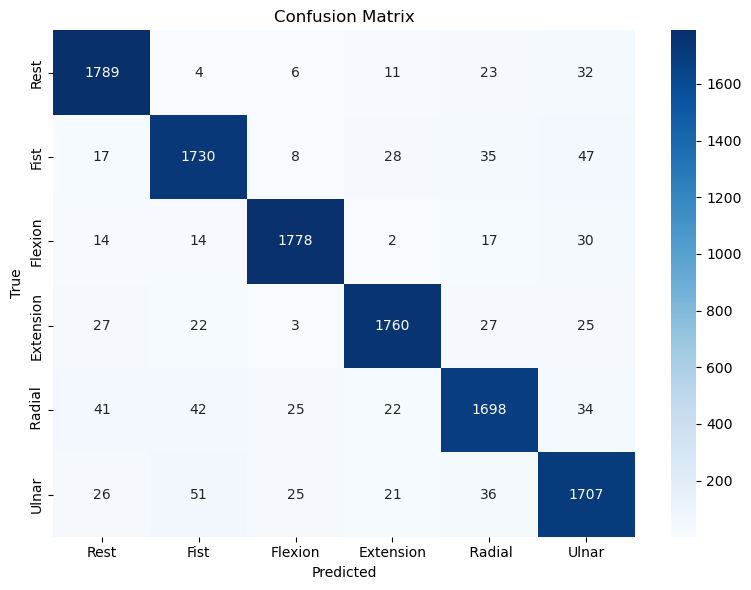

Accuracy:  93.60%
F1 Score:  0.9360
Precision: 0.9361
Recall:    0.9360

Classification Report:
              precision    recall  f1-score   support

        Rest       0.93      0.96      0.95      1865
        Fist       0.93      0.93      0.93      1865
     Flexion       0.96      0.96      0.96      1855
   Extension       0.95      0.94      0.95      1864
      Radial       0.92      0.91      0.92      1862
       Ulnar       0.91      0.91      0.91      1866

    accuracy                           0.94     11177
   macro avg       0.94      0.94      0.94     11177
weighted avg       0.94      0.94      0.94     11177



In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predict class probabilities and get class labels
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[poses[i+1] for i in range(num_classes)],
            yticklabels=[poses[i+1] for i in range(num_classes)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Classification Metrics
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy:  {acc * 100:.2f}%")
print(f"F1 Score:  {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

# Optional: Detailed class-wise report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=[poses[i+1] for i in range(num_classes)]))


In [ ]:
window_duration = 0.128
overlap_percentage = 0.75
sampling_rate = 250

window_size = int(window_duration * sampling_rate)
step_size = int(window_size * (1 - overlap_percentage))

X_seq = []
y_seq = []

for start in range(0, len(data) - window_size, step_size):
    try:
        window = data.iloc[start:start + window_size]
        dominant_class = window['class'].mode()[0]
        emg_matrix = np.stack([window[f' EXG Channel {i}'].values for i in range(8)], axis=1)
        X_seq.append(emg_matrix)
        y_seq.append(dominant_class)
    except:
        continue

X_seq = np.array(X_seq)  # shape: (samples, timesteps, channels)
y_seq = np.array(y_seq)
y_seq -= 1

X_seq, y_seq = shuffle(X_seq, y_seq, random_state=42)

# Encode labels if not already integers
label_encoder = LabelEncoder()
y_seq = label_encoder.fit_transform(y_seq)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, stratify=y_seq)

# Apply n_augments times per original window
n_augments = 0
augmented_X = []
augmented_y = []

for x, y in zip(X_train, y_train):
    for _ in range(n_augments):
        aug = augment_emg_window(x)
        augmented_X.append(aug)
        augmented_y.append(y)

# Concatenate augmented data with original training set
if n_augments > 0:
    X_train = np.concatenate([X_train, np.array(augmented_X)], axis=0)
    y_train = np.concatenate([y_train, np.array(augmented_y)], axis=0)


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def build_cnn(input_shape, n_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv1D(32, kernel_size=5, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        Conv1D(64, kernel_size=3, activation='relu', padding='same'),
        Flatten(),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_lstm(input_shape, n_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        LSTM(32, return_sequences=True),
        LSTM(16),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def build_cnn_lstm(input_shape, n_classes):
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv1D(32, kernel_size=3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=2),
        LSTM(16),
        Dense(16, activation='relu'),
        Dropout(0.3),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def add_noise(x, min_noise_level=0.1, max_noise_level=0.7):
    factor = np.random.uniform(min_noise_level, max_noise_level)
    return x + np.random.normal(0, factor, x.shape)

def scale_amplitude(x, min_scale=0.7, max_scale=1.3):
    factor = np.random.uniform(min_scale, max_scale)
    return x * factor

def augment_emg_window(emg_window):
    augmented = emg_window.copy()
    for ch in range(augmented.shape[1]):
        augmented[:, ch] = scale_amplitude(add_noise(augmented[:, ch]))
    return augmented



Epoch 1/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.5060 - loss: 1.2715 - val_accuracy: 0.8445 - val_loss: 0.5159
Epoch 2/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8264 - loss: 0.5984 - val_accuracy: 0.8813 - val_loss: 0.3978
Epoch 3/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8619 - loss: 0.4892 - val_accuracy: 0.8936 - val_loss: 0.3509
Epoch 4/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8798 - loss: 0.4240 - val_accuracy: 0.9042 - val_loss: 0.3126
Epoch 5/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.8908 - loss: 0.3884 - val_accuracy: 0.9042 - val_loss: 0.3151
Epoch 6/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8993 - loss: 0.3580 - val_accuracy: 0.9119 - val_loss: 0.2915
Epoch 7/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9062 - loss: 0.3329 - val_accuracy: 0.9192 - val_loss: 0.2631
Epoch 8/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9099 - loss: 0.3224 - 

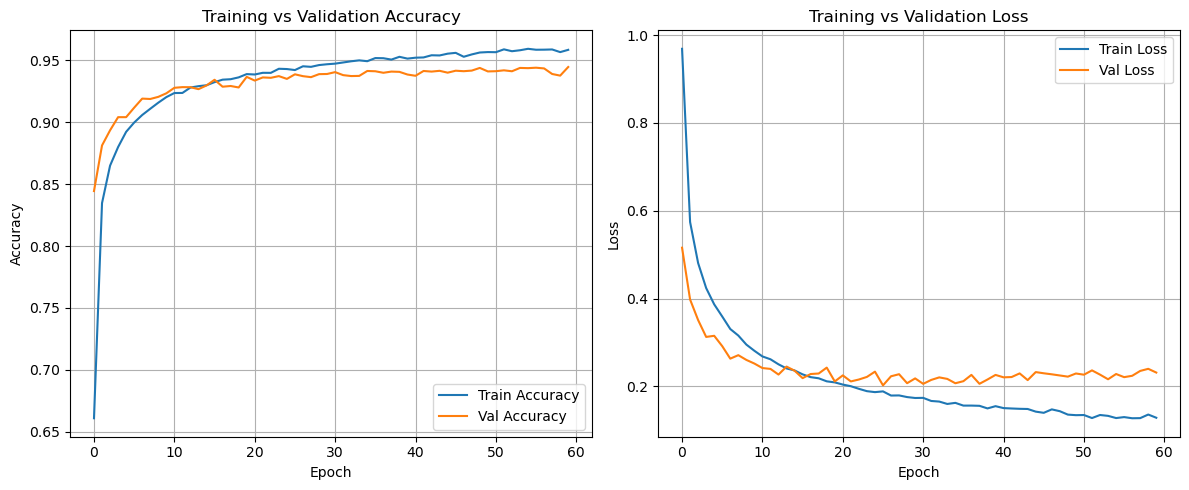

In [ ]:
# LSTM Model
model_lstm = build_lstm(input_shape=(X_train.shape[1], X_train.shape[2]), n_classes=len(np.unique(y_seq)))

# Train
history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = model_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plot_training_curves(history)

Epoch 1/60


/home/ayman/miniconda3/envs/tf-gpu/lib/python3.11/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


827/827 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.5584 - loss: 1.1497 - val_accuracy: 0.8036 - val_loss: 0.5723
Epoch 2/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8102 - loss: 0.5742 - val_accuracy: 0.8557 - val_loss: 0.4371
Epoch 3/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8501 - loss: 0.4621 - val_accuracy: 0.8630 - val_loss: 0.4044
Epoch 4/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8770 - loss: 0.3816 - val_accuracy: 0.8874 - val_loss: 0.3397
Epoch 5/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.8810 - loss: 0.3622 - val_accuracy: 0.8899 - val_loss: 0.3286
Epoch 6/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.8986 - loss: 0.3112 - val_accuracy: 0.8906 - val_loss: 0.3215
Epoch 7/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9074 - loss: 0.2796 - val_accuracy: 0.9057 - val_loss: 0.2833
Epoch 8/60
827/827 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9140 - loss: 0.2608 - val_accuracy: 0.8888 - val_

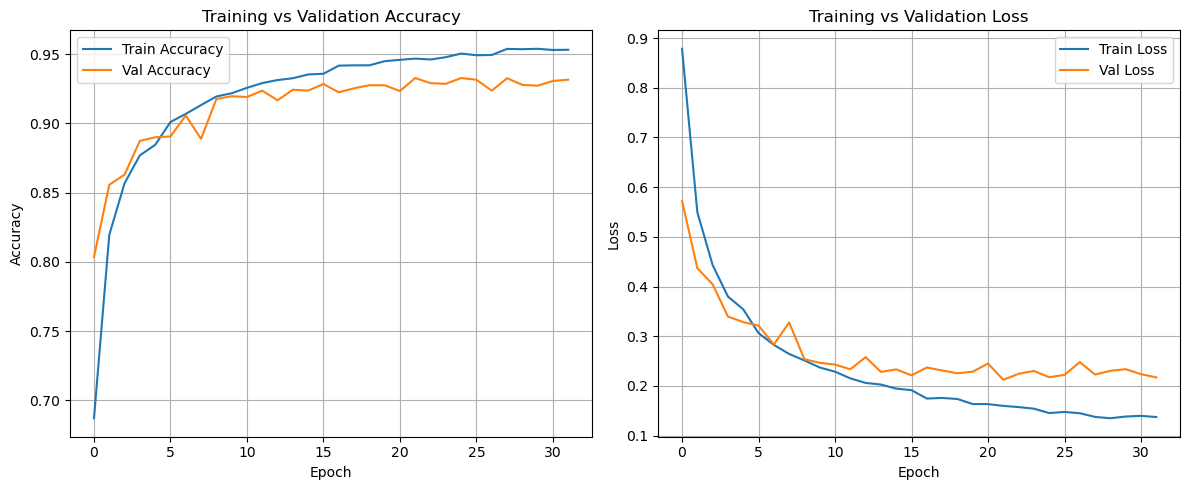

In [114]:
# CNN Model
moden_cnn_lstm = build_cnn_lstm(input_shape=(X_train.shape[1], X_train.shape[2]), n_classes=len(np.unique(y_seq)))

# Train
history = moden_cnn_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=64, callbacks=[early_stop])

# Evaluate
test_loss, test_acc = moden_cnn_lstm.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

plot_training_curves(history)


### figuring out what features are important